<a href="https://colab.research.google.com/github/aneesh-kaitou1412/vae-mnist/blob/master/Convolutional_VAE_MNIST_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional VAE for Denoising Images

In [47]:
''' Imports '''
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
import numpy as np
import matplotlib.pyplot as plt

## Loading MNIST and making a Noisy Dataset

In [48]:
def preprocess(images):
  images = np.expand_dims(images, -1)
  images = images.astype('float32') / 255
  return images

def generate_noisy(images, 
                   loc=0.5, 
                   scale=0.5, 
                   min_value=0.0, 
                   max_value=1.0,
                   percent_distortion=0.65):
  noise = np.random.normal(loc=loc, scale=scale, size=images.shape)
  return np.clip(images + percent_distortion * noise, 
                 min_value, 
                 max_value)
  

def plot_images(images, rows, cols, figsize=None, cmap='gray'):
  if figsize is None:
    figsize = (2 * cols, 2 * rows)
  f, axarr = plt.subplots(rows, cols, figsize=figsize)
  if rows == 1 and cols == 1:
    axarr.imshow(images[0][0], cmap=cmap)
  elif rows == 1:
    for i in range(rows):
      for j in range(cols):
        axarr[j].imshow(images[0][j], cmap=cmap)
  elif cols == 1:
    for i in range(rows):
      for j in range(cols):
        axarr[i].imshow(images[i][0], cmap=cmap)
  else:
    for i in range(rows):
      for j in range(cols):
        axarr[i, j].imshow(images[i][j], cmap=cmap)

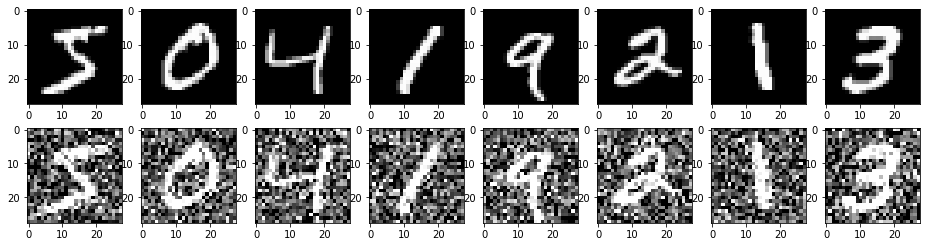

In [49]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

x_train_noisy = generate_noisy(x_train)
x_test_noisy = generate_noisy(x_test)

# Network Parameters
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3],)
batch_size = 128
latent_dim = 2

L = []
for x in [x_train, x_train_noisy]:
  l = []
  for i in range(8):
    l.append(np.reshape(x[i], input_shape[:-1]))
  L.append(l)

plot_images(L, len(L), len(L[0]))

## Build the Variational Autoencoder Model

In [50]:
# Encoder Decoder number of Convolutional Layers and Filters, 
# Kernel Sizes, Stride Sizes
filter_sizes = [32, 64]
kernel_sizes = [3, 3]
stride_sizes = [2, 2]

encoding_activation='relu'
decoding_activation='relu'

In [51]:
# Build the Encoder Model

class SamplingLayer(layers.Layer):
  """ Sampling Latent Space Vector using Reparametrization Trick """
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch_size = tf.shape(z_mean)[0]
    latent_dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


inputs = layers.Input(shape=input_shape, name='encoder_input')
x = inputs

# Stack Convolutional Encoding Layers
for filters, kernel_size, strides in \
    zip(filter_sizes, kernel_sizes, stride_sizes):
  x = layers.Conv2D(filters=filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    activation=encoding_activation,
                    padding='same')(x)

# Final Shape before Dense Unit to build Decoder
encoder_out_shape = K.int_shape(x)
encoder_out_shape = (encoder_out_shape[1], 
                     encoder_out_shape[2], 
                     encoder_out_shape[3])

# Generate Latent Space Paramters
x = layers.Flatten()(x)
z_mean = layers.Dense(units=latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(units=latent_dim, name='z_log_var')(x)
z = SamplingLayer()([z_mean, z_log_var])

# Make the Encoder Model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_12[0][0]                  
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 3136)         0           conv2d_13[0][0]                  
____________________________________________________________________________________________

In [52]:
# Build the Decoder Model

z = layers.Input(shape=(latent_dim,), name='decoder_input')
x = layers.Dense(np.prod(encoder_out_shape))(z)
x = layers.Reshape(encoder_out_shape)(x)

# Stack Deconvolutional Decoding Layers
for filters, kernel_size, strides in \
    list(zip(filter_sizes, kernel_sizes, stride_sizes))[::-1]:
  x = layers.Conv2DTranspose(filters=filters,
                             kernel_size=kernel_size,
                             strides=strides,
                             activation=decoding_activation,
                             padding='same')(x)

# Finally make it into 28x28x1 and then sigmoid activation
x = layers.Conv2DTranspose(filters=1,
                           kernel_size=3,
                           padding='same')(x)
outputs = layers.Activation('sigmoid', name='decoder_output')(x)

# Make the Decoder Model
decoder = Model(z, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0   

## Training the Autoencoder

In [53]:
class VAE(Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    
  def train_step(self, inputs):
    data = inputs[0]
    output = inputs[1]
    with tf.GradientTape() as tape:
      # Encode the Data, to find Mean and Variance
      z_mean, z_log_var, z = self.encoder(data)

      # Reconstruct from the Sampled Point
      reconstruction = self.decoder(z)

      # Calculate Reconstruction Loss
      reconstruction_loss = tf.reduce_mean(
          binary_crossentropy(output, reconstruction)
      )
      reconstruction_loss *= np.prod(input_shape)

      # Calculate KL Divergence Loss
      kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
      kl_loss = tf.reduce_mean(kl_loss)
      kl_loss *= -0.5


      total_loss = reconstruction_loss + kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
    return {
      "loss": total_loss,
      "reconstruction_loss": reconstruction_loss,
      "kl_loss": kl_loss,
    }

In [54]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(x_train_noisy, x_train, epochs=30, batch_size=batch_size)

Epoch 1/30
469/469 [==============================] - 4s 8ms/step - loss: 203.6096 - reconstruction_loss: 200.9403 - kl_loss: 2.6693
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 174.6745 - reconstruction_loss: 172.1873 - kl_loss: 2.4872
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 167.5795 - reconstruction_loss: 164.9303 - kl_loss: 2.6493
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 164.2830 - reconstruction_loss: 161.5347 - kl_loss: 2.7483
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 162.3104 - reconstruction_loss: 159.4709 - kl_loss: 2.8395
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 160.9171 - reconstruction_loss: 158.0415 - kl_loss: 2.8756
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 159.9271 - reconstruction_loss: 156.9992 - kl_loss: 2.9279
Epoch 8/30
469/469 [==============================] - 4s 8ms/step - l

## Apply the Trained Model on Testing Data

Here the noisy test data is first passed through the encoder and then through the decoder

The first 8 images are printed in 3 rows:
* First Row is the noisy test data
* Second Row is the reconstruction after being passed through the VAE
* Third Row is the actual test data (without noise)

In [59]:
x_test_decoded = vae.decoder(vae.encoder(x_test_noisy)[2])
x_test_decoded = np.asarray(x_test_decoded)

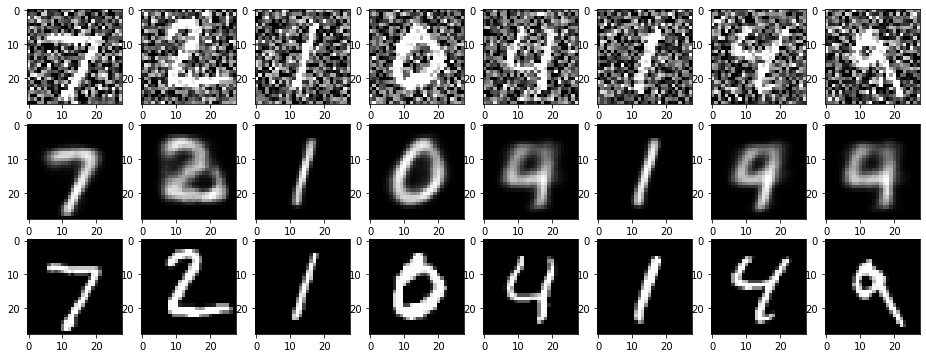

In [60]:
L = []
for x in [x_test_noisy, x_test_decoded, x_test]:
  l = []
  for i in range(8):
    l.append(np.reshape(x[i], input_shape[:-1]))
  L.append(l)

plot_images(L, len(L), len(L[0]))